In [48]:
import torch
from sklearn.preprocessing import StandardScaler
samples = 100000

data_name = "val"
R=0

i = torch.randn((samples,2))*10
iscaler = StandardScaler()
i_scaled = iscaler.fit_transform(i)

psi = torch.column_stack([i[:,0]**2+i[:,1],i[:,0]-i[:,1]**2])
#psi_scaler = StandardScaler(with_mean=False)
#psi_scaled = psi_scaler.fit_transform(psi)

ones = torch.ones((samples,))
L = torch.column_stack((2*i[:,0],ones,ones,-2*i[:,1]))

sigma_i = torch.ones((samples,2))*iscaler.scale_
#sigma_psi = torch.ones((samples,2))*psi_scaler.scale_
i_scaled = torch.from_numpy(i_scaled).float()
#psi_scaled = torch.from_numpy(psi_scaled).float()

#data = {"i":i_scaled,"psi":psi_scaled}
#test_data = {"i":i[::100,:],"psi":psi[::100,:],"i_scaled":i_scaled[::100,:],"sigma_i":sigma_i[::100,:],"l":L[::100,:],"sigma_psi":sigma_psi[::100,:]}
data = {"i":i_scaled,"psi":psi}
test_data = {"i":i[::100,:],"psi":psi[::100,:],"i_scaled":i_scaled[::100,:],"sigma_i":sigma_i[::100,:],"l":L[::100,:]}

C:\Users\JANLUKS\AppData\Local\Temp\ipykernel_21324\1023359615.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sigma_i = torch.ones((samples,2))*iscaler.scale_


In [49]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import mlflow

class FluxModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2,40),
            nn.Tanh(),
            nn.Linear(40,40),
            nn.Tanh(),
            nn.Linear(40,2),
        )
        self.r = nn.Parameter(torch.tensor([0], dtype=float,requires_grad=True))
        
    def forward(self,x):
        return self.model(x),self.r

def log_visualization(data, pred, titles, color_label, plot_filename, value_range_indices, display=False):
    fig, ax = plt.subplots( 2, len(titles)//2, figsize=(8 * len(titles)//4, 6))
    ax = ax.reshape((len(titles),))
    combined_data = torch.column_stack((data, pred))
    
    # Determine value range
    pred_max = torch.max(pred, axis=0)[0]
    data_max = torch.max(data, axis=0)[0]
    max_values = torch.maximum(pred_max, data_max)
    
    pred_min = torch.min(pred, axis=0)[0]
    data_min = torch.min(data, axis=0)[0]
    min_values = torch.minimum(pred_min, data_min)
    
    # Create scatter plots
    for i in range(len(titles)):
        sc = ax[i].scatter(test_data["i"][:, 0], test_data["i"][:, 1], marker=".", c=combined_data[:, i], cmap='viridis',
                           vmin=min_values[value_range_indices[i]], vmax=max_values[value_range_indices[i]])
        
        # Add a color bar
        cbar = plt.colorbar(sc, ax=ax[i])
        cbar.set_label(color_label)
        
        # Set equal scaling for x and y axes and adjust the plot box
        ax[i].set_aspect('equal', 'box')
        
        # Add labels and title
        ax[i].set_xlabel('id [A]')
        ax[i].set_ylabel('iq [A]')
        ax[i].set_title(titles[i])
    
    # Adjust layout to fit everything nicely
    plt.tight_layout()
    plt.savefig(plot_filename)
    if not display:
        plt.close(fig)
    mlflow.log_artifact(plot_filename)

# Example usage for log_psi_error_plane
def log_psi_error_plane(pred, display=False):
    error = torch.abs(test_data["psi"] - pred)
    log_visualization(
        data=error,
        pred=error,
        titles=["Psid", "Psiq"],
        color_label='MAE [Wb]',
        plot_filename="Psi_mae.png",
        value_range_indices=[0, 1],
        display=display
    )

# Example usage for log_l_visualization
def log_l_visualization(pred, display=False):
    log_visualization(
        data=test_data["l"],
        pred=pred,
        titles=[
            "ldq from table", "ldq from table", "lqd from table", "lqq from table",
            "ldd estimated", "ldq estimated", "lqd estimated", "lqq estimated"
        ],
        color_label='l [Wb/A]',
        plot_filename="L.png",
        value_range_indices=[0, 1, 2, 3, 0, 1, 2, 3],
        display=display
    )

# Example usage for log_prediction_visualization
def log_prediction_visualization(pred, display=False):
    log_visualization(
        data=test_data["psi"],
        pred=pred,
        titles=["Psid from flux table", "Psiq from flux table", "Psid estimated", "Psiq estimated"],
        color_label='Psi [Wb]',
        plot_filename="Psi.png",
        value_range_indices=[0, 1, 0, 1],
        display=display
    )
"""ConnectionError  
def compute_differential_inductances(model):
    model.eval()
    jacobi = torch.autograd.functional.jacobian(model.model,test_data["i_scaled"])
    inductances = torch.diagonal(jacobi,dim1=0,dim2=2)
    print(inductances)
    scale = torch.div(torch.from_numpy(psi_scaler.scale_),torch.from_numpy(iscaler.scale_))#test_data["sigma_psi"],test_data["sigma_i"])
    scale = scale.view(-1, 1)
    inductances = torch.mul(inductances,scale)
    inductances = inductances.reshape((4,inductances.shape[2])).transpose(0,1)
    return inductances
    """
def compute_differential_inductances(model):
    model.eval()
    jacobi = torch.autograd.functional.jacobian(model.model,test_data["i_scaled"])
    inductances = torch.diagonal(jacobi,dim1=0,dim2=2)
    sigma = torch.from_numpy(iscaler.scale_).view(-1,1)
    inductances = torch.div(inductances,sigma)
    inductances = inductances.reshape((4,inductances.shape[2])).transpose(0,1)
    return inductances

def calc_derivative(outputs,inputs):
    partial_derivatives = []
    for i in range(outputs.shape[1]):
        grad_outputs = torch.zeros_like(outputs)
        grad_outputs[:, i] = 1
        grads = torch.autograd.grad(outputs, inputs, grad_outputs=grad_outputs, create_graph=True)[0]
        print(grads)
        sigma = torch.from_numpy(iscaler.scale_)
        grads = torch.div(grads,sigma)
        partial_derivatives.append(grads)
    return partial_derivatives


In [58]:
model=FluxModel()
loss_fn = torch.nn.L1Loss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.1)

epochs = 500
batchsize = 1024
for e in range(epochs):
    for i in range(0,samples,batchsize):
        model.train()
        pred,r = model(data["i"][i:i+batchsize,:])
        loss = loss_fn(pred,data["psi"][i:i+batchsize,:])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f" epoch {e} : loss {loss}")
    

 epoch 0 : loss 81.14342498779297
 epoch 1 : loss 73.35353088378906
 epoch 2 : loss 69.6047592163086
 epoch 3 : loss 67.91959381103516
 epoch 4 : loss 65.78807830810547
 epoch 5 : loss 63.63265609741211
 epoch 6 : loss 62.676204681396484
 epoch 7 : loss 64.27664947509766
 epoch 8 : loss 61.89800262451172
 epoch 9 : loss 61.37792205810547
 epoch 10 : loss 62.06124496459961
 epoch 11 : loss 62.066017150878906
 epoch 12 : loss 60.84702682495117
 epoch 13 : loss 47.67780685424805
 epoch 14 : loss 41.106719970703125
 epoch 15 : loss 40.49540328979492
 epoch 16 : loss 37.04663848876953
 epoch 17 : loss 34.42100524902344
 epoch 18 : loss 28.441205978393555
 epoch 19 : loss 28.160659790039062
 epoch 20 : loss 27.025495529174805
 epoch 21 : loss 25.913137435913086
 epoch 22 : loss 27.24599266052246
 epoch 23 : loss 31.313148498535156
 epoch 24 : loss 24.80813217163086
 epoch 25 : loss 24.289331436157227
 epoch 26 : loss 19.359899520874023
 epoch 27 : loss 23.95389175415039
 epoch 28 : loss 21.3

KeyboardInterrupt: 

tensor([[ 134.0084,   10.6096],
        [-184.5580,   18.2085],
        [ 373.7312,    5.0683],
        ...,
        [ 185.6672,   12.1357],
        [ -18.4679,   11.7376],
        [ 276.7340,    6.4566]], grad_fn=<MmBackward0>)
tensor([[   8.1680,  -61.4248],
        [  14.0934,   -4.2684],
        [  16.6394,  201.1838],
        ...,
        [  13.9825,   10.1304],
        [  -3.5135,  402.1654],
        [ -15.9852, -283.9107]], grad_fn=<MmBackward0>)


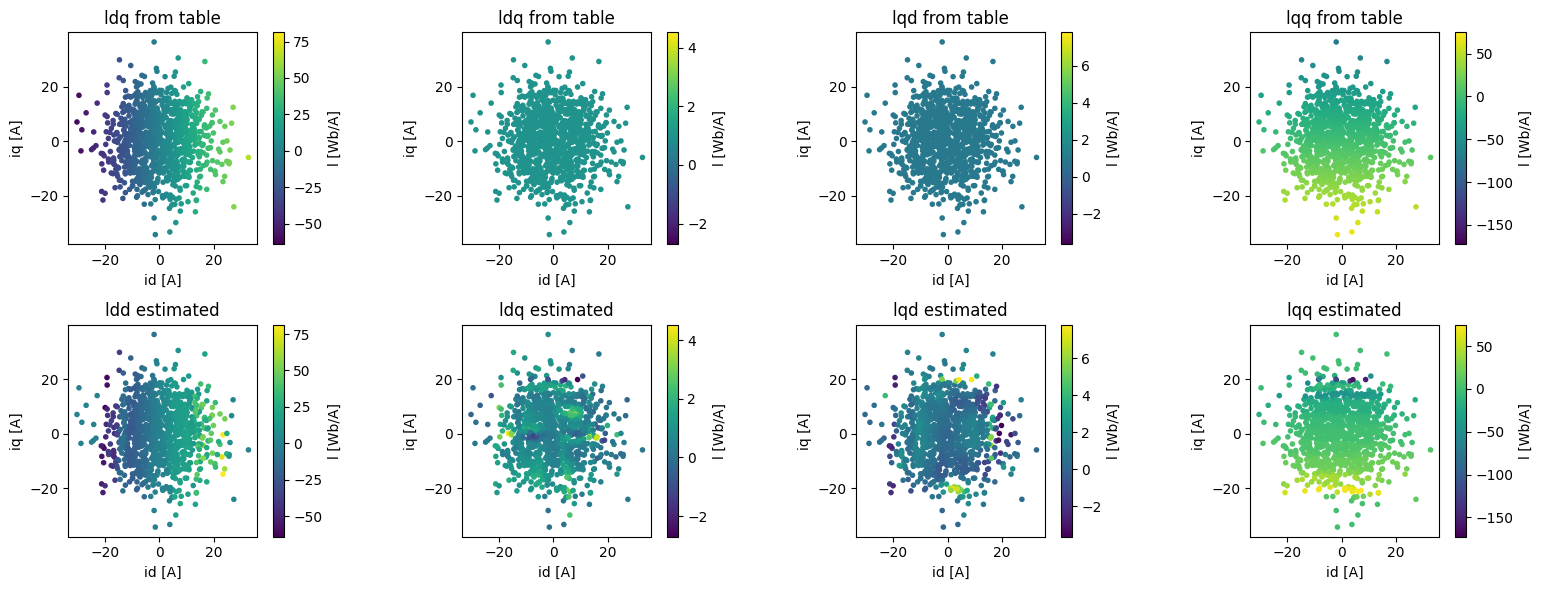

In [60]:
inputs = test_data["i_scaled"].clone().detach().requires_grad_(True)
pred,r = model(inputs)

deriv = calc_derivative(pred,inputs)
deriv = torch.column_stack(deriv)
deriv = deriv.detach()
log_l_visualization(deriv,display=True)

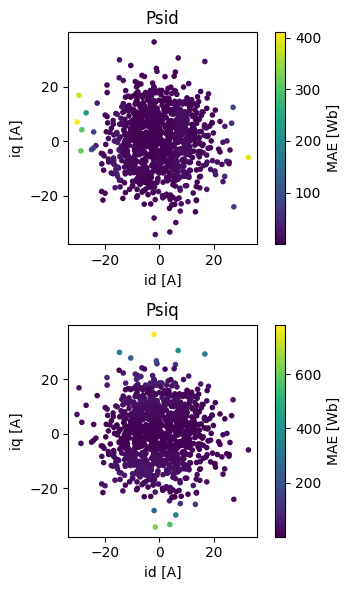

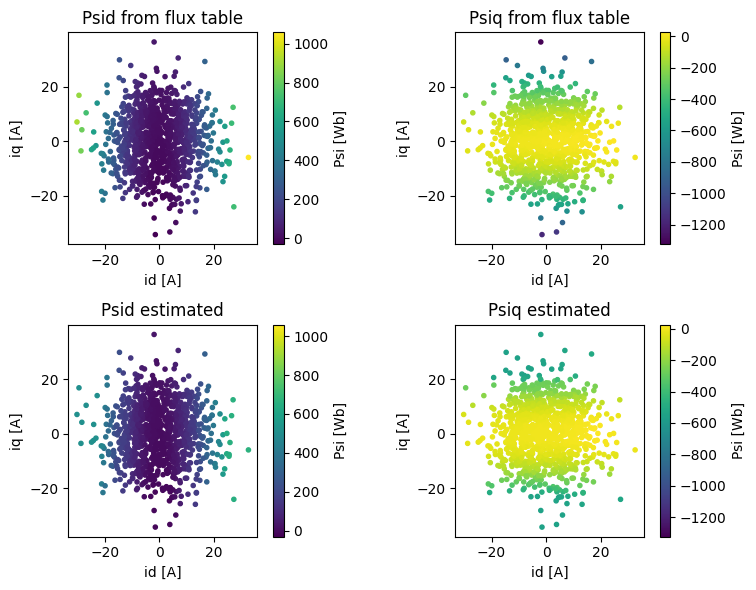

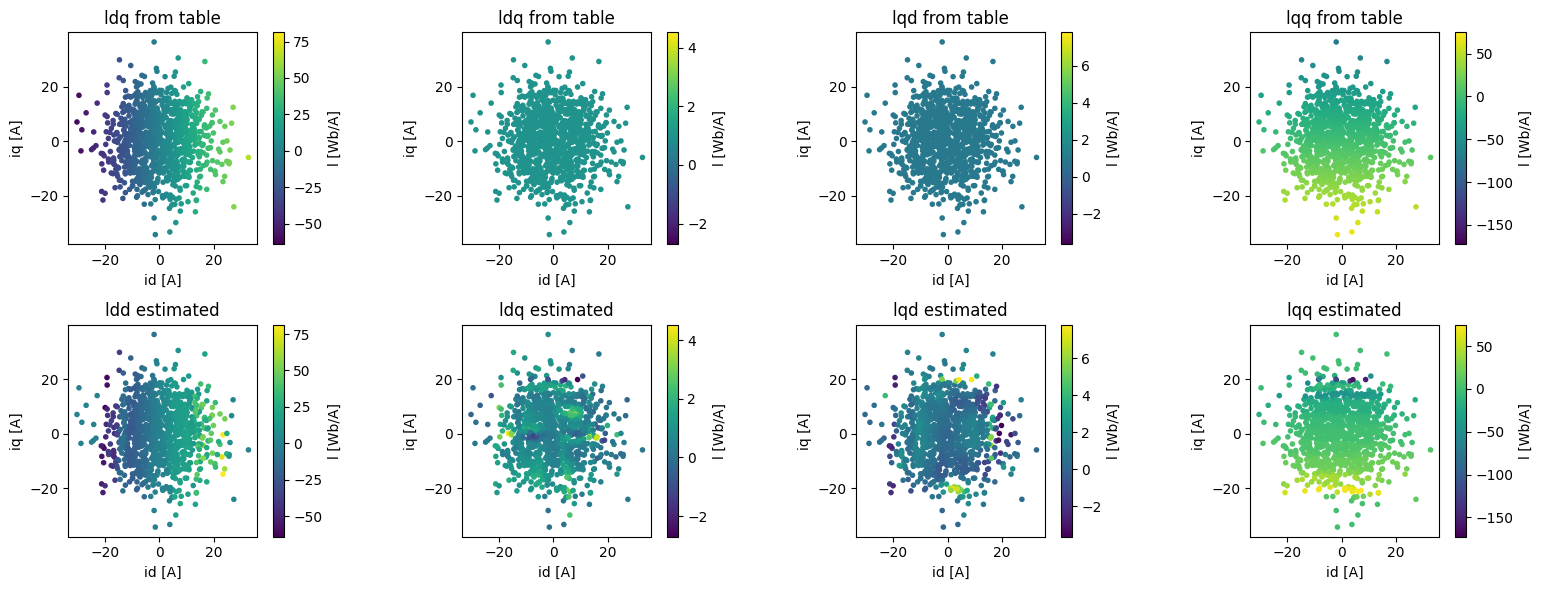

In [59]:
model.eval()
with torch.no_grad():
    pred,r = model(test_data["i_scaled"])
    #pred = pred*test_data["sigma_psi"]
    log_psi_error_plane(pred,display=True)
    log_prediction_visualization(pred,display=True)
    deriv = compute_differential_inductances(model)
    log_l_visualization(deriv,display=True)